# Install Packages

In [1]:
!pip install -qU langchain\
    langchain-community\
    langchain-together\
    langchain-core\
    faiss-cpu\
    faiss-gpu\
    langgraph\
    sentence-transformers\
    gradio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.9.0 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
cudf 24.6.1 requires cuda-python<12.0a0,>=11.7.1, but you have cu

In [2]:
!pip install rank_bm25
#!pip install -U langchain-community tavily-python

# Import Packages

In [3]:
import os
import requests
from bs4 import BeautifulSoup
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.embeddings import CacheBackedEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from tqdm import tqdm
import torch
import numpy as np
import faiss
from langchain_together import ChatTogether
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
from langchain.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from typing import List, Dict, Any
import gradio as gr
from uuid import uuid4
from langchain_core.output_parsers.string import StrOutputParser
from typing import TypedDict, List, Dict
from langchain_core.messages.base import BaseMessage
from langgraph.graph import StateGraph, END
from io import BytesIO
from PIL import Image
from IPython.display import display
from langchain.storage import LocalFileStore
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.documents.base import Document as LangchainDocument
from pydantic import RootModel
from langchain_community.retrievers import TavilySearchAPIRetriever
from operator import itemgetter
from langchain_core.messages import HumanMessage, AIMessage
from IPython.core.display import Markdown
from langchain_core.output_parsers import BaseGenerationOutputParser
from langchain_core.outputs import ChatGeneration, Generation
from typing import Iterator
from langchain_core.runnables import RunnableLambda


In [4]:
os.environ["TAVILY_API_KEY"] = "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"
os.environ["TOGETHER_API_KEY"] = "06f694fa099c8698aac70c8678a43e6d58bf4a2e4f44d9f3d1cfd4345c37c1b3"

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Part 1 - Data and Preprocessing 

## 1-1 Chapter Links

In [7]:
url = "https://stanford.edu/~jurafsky/slp3/"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
chapter_links = []

for tr in soup.find_all('tr'):
    tds = tr.find_all('td')
    if len(tds) > 1:
        chapter_number = tds[0].get_text().strip()
        if chapter_number and (chapter_number[0].isdigit() or chapter_number[0].isalpha()) and ':' in chapter_number:
            a_tag = tds[1].find('a', href=True)
            if a_tag and a_tag['href'].endswith('.pdf'):
                chapter_name = a_tag.get_text().strip()
                chapter_link = url + a_tag['href']
                chapter_links.append((chapter_name, chapter_link))

for name, link in chapter_links:
    print(f'{name}:\n {link}')

Regular Expressions, Text Normalization, Edit Distance:
 https://stanford.edu/~jurafsky/slp3/2.pdf
N-gram Language Models:
 https://stanford.edu/~jurafsky/slp3/3.pdf
Naive Bayes, Text Classification,  and Sentiment:
 https://stanford.edu/~jurafsky/slp3/4.pdf
Logistic Regression:
 https://stanford.edu/~jurafsky/slp3/5.pdf
Vector Semantics and Embeddings:
 https://stanford.edu/~jurafsky/slp3/6.pdf
Neural Networks and Neural Language Models:
 https://stanford.edu/~jurafsky/slp3/7.pdf
Sequence Labeling for Parts of Speech and Named Entities:
 https://stanford.edu/~jurafsky/slp3/8.pdf
RNNs and LSTMs:
 https://stanford.edu/~jurafsky/slp3/9.pdf
Transformers and Large Language Models:
 https://stanford.edu/~jurafsky/slp3/10.pdf
Fine-tuning and Masked Language Models:
 https://stanford.edu/~jurafsky/slp3/11.pdf
Machine Translation:
 https://stanford.edu/~jurafsky/slp3/13.pdf
Question Answering and Information Retrieval:
 https://stanford.edu/~jurafsky/slp3/14.pdf
Chatbots and Dialogue Systems:


## 1-2 Convert PDF links to text using PdfLoader

In [8]:
documents = []
for name, link in chapter_links:
    print(f'Processing {name}: {link}')
    loader = PyPDFLoader(link)
    pdf_docs = loader.load()
    documents.extend(pdf_docs)

Processing Regular Expressions, Text Normalization, Edit Distance: https://stanford.edu/~jurafsky/slp3/2.pdf
Processing N-gram Language Models: https://stanford.edu/~jurafsky/slp3/3.pdf
Processing Naive Bayes, Text Classification,  and Sentiment: https://stanford.edu/~jurafsky/slp3/4.pdf
Processing Logistic Regression: https://stanford.edu/~jurafsky/slp3/5.pdf
Processing Vector Semantics and Embeddings: https://stanford.edu/~jurafsky/slp3/6.pdf
Processing Neural Networks and Neural Language Models: https://stanford.edu/~jurafsky/slp3/7.pdf
Processing Sequence Labeling for Parts of Speech and Named Entities: https://stanford.edu/~jurafsky/slp3/8.pdf
Processing RNNs and LSTMs: https://stanford.edu/~jurafsky/slp3/9.pdf
Processing Transformers and Large Language Models: https://stanford.edu/~jurafsky/slp3/10.pdf
Processing Fine-tuning and Masked Language Models: https://stanford.edu/~jurafsky/slp3/11.pdf
Processing Machine Translation: https://stanford.edu/~jurafsky/slp3/13.pdf
Processing 

### Print to Verify

In [9]:
#for doc in documents:
#    print(f'Document Metadata: {doc.metadata}')
#    print(f'Document Content:\n{doc.page_content[:500]}')  
#    print('...')

## 1-3 Split the documents into chunks

In [10]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
chunks = text_splitter.split_documents(documents)

In [11]:
for i, split_doc in enumerate(chunks[:5]): 
    print(f'Chunk {i+1}:\n{split_doc.page_content[:500]}\n...')

Chunk 1:
Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright ©2023. All
rights reserved. Draft of February 3, 2024.
CHAPTER
2Regular Expressions, Text
Normalization, Edit Distance
User: I am unhappy.
ELIZA: DO YOU THINK COMING HERE WILL HELP YOU NOT TO BE UNHAPPY
User: I need some help, that much seems certain.
ELIZA: WHAT WOULD IT MEAN TO YOU IF YOU GOT SOME HELP
User: Perhaps I could learn to get along with my mother.
ELIZA: TELL ME MORE ABOUT YOUR FAMILY
User: My mother takes 
...
Chunk 2:
them into suitable outputs like “What would it mean to you if you got X?”. This
simple technique succeeds in this domain because ELIZA doesn’t actually need to
know anything to mimic a Rogerian psychotherapist. As Weizenbaum notes, this is
one of the few dialogue genres where listeners can act as if they know nothing of the
world. ELIZA’s mimicry of human conversation was remarkably successful: many
people who interacted with ELIZA came to believe that it really understood

# Part 2 - Generate and store embeddings

In [12]:
os.makedirs("/kaggle/working/cache", exist_ok=True)
store = LocalFileStore("/kaggle/working/cache/")

## Load model

In [13]:
embedding_function = HuggingFaceEmbeddings(show_progress=True, multi_process=True,model_kwargs={'device': 'cuda'})

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
embedding_function.model_name

'sentence-transformers/all-mpnet-base-v2'

In [15]:
embedder = CacheBackedEmbeddings.from_bytes_store(
    embedding_function,
    store,
    namespace="sentence-transformers/all-mpnet-base-v2"
)

In [16]:
vector_store = FAISS.from_documents(documents=chunks, embedding=embedder)

In [17]:
num_chunks = len(chunks)
print(f"Number of chunks: {num_chunks}")

Number of chunks: 2487


In [18]:
num_embeddings = vector_store.index.ntotal
print(f"Number of embeddings in the FAISS index: {num_embeddings}")

Number of embeddings in the FAISS index: 2487


# Part 3 - Hybrid Retriever

##  BM25 Retriever (Sparse Embedding)

In [19]:
bm25_retriever = BM25Retriever.from_documents(chunks)
bm25_retriever.k=3

## FAISS Retriever (Dense Embedding)

In [20]:
faiss_retriever = vector_store.as_retriever(search_kwargs={"k": 3})

## Ensemble Retriever

In [21]:
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5])

In [22]:
def test_weights(ensemble_retriever, queries):
    for weight in [0.7, 0.6, 0.5, 0.4, 0.3]:
        print(f"\nWeights: BM25: {1-weight}, FAISS: {weight}")
        ensemble_retriever.weights = [1-weight, weight]
        for query in queries:
            print(f"\nQuery: {query}")
            results = ensemble_retriever.get_relevant_documents(query)
            for i, result in enumerate(results[:3]):
                print(f"Result {i+1}: {result.page_content[:400]}... \n")

queries = [
    "Multihead self attention layers",
    "Maximum Spanning Tree",
    "Who is the elected president of Iran?"
]

test_weights(ensemble_retriever, queries)


Weights: BM25: 0.30000000000000004, FAISS: 0.7

Query: Multihead self attention layers


/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Result 1: 10.2 • M ULTIHEAD ATTENTION 9
10.2 Multihead Attention
Transformers actually compute a more complex kind of attention than the single
self-attention calculation we’ve seen so far. This is because the different words in a
sentence can relate to each other in many different ways simultaneously. For exam-
ple, distinct syntactic, semantic, and discourse relationships can hold between verbs
and their ... 

Result 2: 10 CHAPTER 10 • T RANSFORMERS AND LARGE LANGUAGE MODELS
Multihead  Attention Layer with h=4 heads…x1x2x3xNConcatenateOutputs[N x hdv]WO  [hdv x d]head1 output val [N x dv]head3 output val [N x dv]head2 output val [N x dv]head4 output val [N x dv]
WQ1, WK1, WV1 WQ3, WK3, WV3 WQ2, WK2, WV2 WQ4, WK4, WV4 Head 1Project fromhdv to d
Head 2Head 3Head 4a1a2a3aN…[N x d]
[N x d]
Figure 10.5 Multihead self-... 

Result 3: at the same level of abstraction.
To implement this notion, each head, i, in a self-attention layer is provided with
its own set of key, query and value matri

In [23]:
ensemble_retriever.weights = [0.4, 0.6]

In [24]:
queries = [
    "Frame-Based Dialogue Systems",
    "Dynamic Programming in Algorithm Design",
    "In what year did the Titanic sink?"
]
for query in queries:
    print(f"\nQuery: {query}")
    results = ensemble_retriever.get_relevant_documents(query)
    for i, result in enumerate(results[:3]):
        print(f"Result {i+1}: {result.page_content[:300]}...\n")


Query: Frame-Based Dialogue Systems
Result 1: 15.2 Frame-Based Dialogue Systems
Atask-based dialogue system has the goal of helping a user solve a speciﬁc task
like making an travel reservation or buying a product. Task-based dialogue systems
are based around frames , ﬁrst introduced in the early inﬂuential GUS system for frame
GUS travel plann...

Result 2: 15.2 • F RAME -BASED DIALOGUE SYSTEMS 7
sometimes called a domain ontology .
Here we’ll describe the most well-studied frame-based architecture, the dialogue-
state architecture, made up of the six components shown in Fig. 15.3. In the next
sections we’ll introduce four of them, after introducing th...

Result 3: 20 CHAPTER 15 • C HATBOTS & D IALOGUE SYSTEMS
descendants use rules to map user sentences into system responses. Corpus-
based chatbots mine logs of human conversation to learn to automatically map
user sentences into system responses.
• For task-based dialogue, most commercial dialogue systems use ...


Query: Dynamic Pr

In [25]:
queries = [
    "Masked Language Modeles",
    "Depth-First Search",
    "What is the capital of Brazil?"
]
for query in queries:
    print(f"\nQuery: {query}")
    results = ensemble_retriever.get_relevant_documents(query)
    for i, result in enumerate(results[:3]):
        print(f"Result {i+1}: {result.page_content[:300]}...\n")


Query: Masked Language Modeles
Result 1: This approach can be generalized to any of a variety of methods that corrupt the
training input and then asks the model to recover the original input. Examples of the
kinds of manipulations that have been used include masks, substitutions, reorder-
ings, deletions, and extraneous insertions into the...

Result 2: We’ll also introduce two important ideas that are often used with these masked
language models. The ﬁrst is the idea of ﬁne-tuning . Fine-tuning is the process ﬁne-tuning
of taking the network learned by these pretrained models, and further training the
model, often via an added neural net classiﬁer...

Result 3: models is important as a way of understanding issues of toxicity, bias, privacy, and
fair use, making it extremely important that language models include datasheets
(page ??) ormodel cards (page ??) giving full replicable information on the cor-
pora used to train them. Open-source models can specif...


Query: Depth-First Sea

# Part 4 - Router Chain

### Model from ChatTogether

In [26]:
sample_llm = ChatTogether(model_name="meta-llama/Llama-3-70b-chat-hf", temperature=0)

### Use ChatPromptTemplate to create input prompt

In [27]:
router_prompt_template = (
    "You are an expert in routing user queries to the appropriate resource for our Natural Language Processing (NLP) course.\n"
    "VectorStore contains detailed information and in-depth explanations about the NLP topics.\n"
    "Based on the user query, decide which resource to use:\n"
    "1. 'VectorStore' for specific queries related to NLP course topics.\n"
    "2. 'SearchEngine' for general information and broad queries about NLP or related fields.\n"
    "If the query is not related to NLP course content, select 'None'.\n"
    "Respond with only the name of the tool you chose and nothing more. If there is no suitable tool, respond with 'None'.\n"
    "{output_instructions}\n"
    "User Query: {query}"
)
sample_prompt = ChatPromptTemplate.from_template(template=router_prompt_template)

### Processing the LLM Output

In [28]:
class ToolSelectionParser(BaseModel):
    tool_name: Literal["VectorStore", "SearchEngine", "None"] = Field(
        description="The selected tool must be one of the following: VectorStore, SearchEngine, or None."
    )

sample_parser = PydanticOutputParser(pydantic_object=ToolSelectionParser)
sample_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"tool_name": {"description": "The selected tool must be one of the following: VectorStore, SearchEngine, or None.", "enum": ["VectorStore", "SearchEngine", "None"], "title": "Tool Name", "type": "string"}}, "required": ["tool_name"]}\n```'

## Create Router Chain

In [29]:
router_chain = sample_prompt | sample_llm | sample_parser

### Testing Router Chain

In [30]:
sample_input = "Elected President of Iran"
router_chain.invoke({
    "query": sample_input,
    "output_instructions": sample_parser.get_format_instructions()
})

ToolSelectionParser(tool_name='None')

In [31]:
sample_input = "How to get A+ in DeepLearning Course"
router_chain.invoke({
    "query": sample_input,
    "output_instructions": sample_parser.get_format_instructions()
})

ToolSelectionParser(tool_name='None')

In [32]:
sample_input = "How does multihead attention work?"
router_chain.invoke({
    "query": sample_input,
    "output_instructions": sample_parser.get_format_instructions()
})

ToolSelectionParser(tool_name='VectorStore')

In [33]:
sample_input = "Is NLP related to machine learning and deep learning?"
router_chain.invoke({
    "query": sample_input,
    "output_instructions": sample_parser.get_format_instructions()
})

ToolSelectionParser(tool_name='SearchEngine')

In [34]:
sample_input = "Can you explain the current trends in NLP research and development?"
router_chain.invoke({
    "query": sample_input,
    "output_instructions": sample_parser.get_format_instructions()
})

ToolSelectionParser(tool_name='SearchEngine')

In [35]:
sample_input = "Elected President of Iran"
output = router_chain.invoke({
    "query": sample_input,
    "output_instructions": sample_parser.get_format_instructions()
})
output.tool_name

'None'

# Part 5 - Search Engine Chain

## Tavily search tool

In [5]:
#search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults()

### Testing Search Engine Output Format

In [39]:
sample_input = "Who is the elected president of Iran?"
search_results = tavily_tool.invoke(sample_input)
print(search_results)

[{'url': 'https://www.cnn.com/2024/07/05/middleeast/pezeshkian-wins-irans-vote-intl-hnk/index.html', 'content': "Newly-elected Iranian President Masoud Pezeshkian is cheered by supporters as he arrives at the shrine of the Islamic Republic's founder Ayatollah Ruhollah Khomeini in Tehran on July 6, 2024. Atta ..."}, {'url': 'https://www.reuters.com/world/middle-east/irans-pezeshkian-brings-hopes-moderation-after-routing-hardline-rival-2024-07-06/', 'content': "Iran's president-elect, low-profile moderate Masoud Pezeshkian, carries the hopes of millions of Iranians seeking less restrictions on social freedoms and a more pragmatic foreign policy."}, {'url': 'https://www.bbc.com/news/articles/cx824yl3ln4o', 'content': "Reformist Masoud Pezeshkian has been elected as Iran's new president, beating his hardline conservative rival Saeed Jalili. The vote was declared in Dr Pezeshkian's favour after he secured 53.3% ..."}, {'url': 'https://www.politico.com/news/2024/07/06/heart-surgeon-who-rose-

In [38]:
sample_input = "Is it harmful to stay up at night to do homework?"
tavily_tool.invoke(sample_input)

[{'url': 'https://www.wikihow.com/Stay-Up-All-Night-Doing-Homework',
  'content': "Staying up all night to do homework is not advised, but sometimes it's unavoidable. If your homework has piled up to the point that the only way to complete it is to pull an all-nighter, then make some preparations and get your head in the game. You're in for a long night."},
 {'url': 'https://www.medicalnewstoday.com/articles/325335',
  'content': 'Sometimes it is necessary for people to stay up all night for work, studying, or other reasons. Tips that may help a person feel more awake and alert at night can include consuming caffeine ...'},
 {'url': 'https://www.westlionsroar.com/features/2021/02/25/the-effects-homework-can-have-on-teens-sleeping-habits/',
  'content': 'Homework is pretty stressful for teens, especially if they have other things to do. Many teens have long hours at school, which limits the time for them to do their insane amount of homework, attend extra-curricular activities, eat, do 

## Search Engine Chain

### Use RunnableLambda 

In [6]:
def dict_to_documents(data: List[Dict[str, str]]) -> List[Document]:
    documents = []
    for item in data:
        doc = Document(page_content=item['content'], metadata={"source": item['url']})
        documents.append(doc)
    return documents

custom_parser = RunnableLambda(dict_to_documents)

In [7]:
search_engine_chain = tavily_tool | custom_parser

In [66]:
sample_input = "Who is the elected president of Iran?"

search_result = search_engine_chain.invoke(sample_input)
search_result

[Document(metadata={'source': 'https://www.cnn.com/2024/07/05/middleeast/pezeshkian-wins-irans-vote-intl-hnk/index.html'}, page_content="Newly-elected Iranian President Masoud Pezeshkian is cheered by supporters as he arrives at the shrine of the Islamic Republic's founder Ayatollah Ruhollah Khomeini in Tehran on July 6, 2024. Atta ..."),
 Document(metadata={'source': 'https://www.reuters.com/world/middle-east/irans-pezeshkian-brings-hopes-moderation-after-routing-hardline-rival-2024-07-06/'}, page_content="Iran's president-elect, low-profile moderate Masoud Pezeshkian, carries the hopes of millions of Iranians seeking less restrictions on social freedoms and a more pragmatic foreign policy."),
 Document(metadata={'source': 'https://www.bbc.com/news/articles/cx824yl3ln4o'}, page_content="Reformist Masoud Pezeshkian has been elected as Iran's new president, beating his hardline conservative rival Saeed Jalili. The vote was declared in Dr Pezeshkian's favour after he secured 53.3% ..."),

In [70]:
sample_input = "Is it harmful to stay up at night to do homework?"

search_result = search_engine_chain.invoke(sample_input)
search_result

[Document(metadata={'source': 'https://www.wikihow.com/Stay-Up-All-Night-Doing-Homework'}, page_content="Use this time to get up and walk around and give your brain a break. 5. Pump yourself up with a nap. If you're tired before starting your work, take a caffeine nap. Drink a cup of coffee, then immediately take a 20-minute nap. The caffeine will take effect just as you wake up and you'll feel refreshed and energized."),
 Document(metadata={'source': 'https://www.medicalnewstoday.com/articles/325335'}, page_content='Try using blackout curtains or eye masks when sleeping during the day. Sometimes it is necessary for people to stay up all night for work, studying, or other reasons. Tips that may help a person ...'),
 Document(metadata={'source': 'https://www.sciencedaily.com/releases/2016/09/160919162837.htm'}, page_content='Most people need at least seven to eight hours of sleep at night for the body and brain to function normally. So, if you stay up all night, missing out on the recom

In [84]:
sample_input = "How does Multihead Attention Works?"

search_result = search_engine_chain.invoke(sample_input)
search_result

[Document(metadata={'source': 'https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853'}, page_content='Essential Techniques\nA Gentle Guide to Feature Engineering and Visualization with Geospatial data, in Plain English\ntowardsdatascience.com\nImage Captions with Deep Learning: State-of-the-Art Architectures\nA Gentle Guide to Image Feature Encoders, Sequence Decoders, Attention, and Multi-modal Architectures, in Plain English\ntowardsdatascience.com\nLet’s keep learning!\n--\n--\n25\nWritten by Ketan Doshi\nTowards Data Science\nMachine Learning and Big Data\nHelp\nStatus\nAbout\nCareers\nBlog\nPrivacy\nTerms\nText to speech\nTeams After passing through the Layer Norm, this is fed to the Query parameter in the Encoder-Decoder Attention in the first Decoder\nEncoder-Decoder Attention\nAlong with that, the output of the final Encoder in the stack is passed to the Value and Key parameters in the Encoder-Decoder Attention.\n How 

In [85]:
for i, doc in enumerate(search_result):
    print(f"\nDocument {i+1}:")
    print(f"URL: {doc.metadata['source']}")
    print(f"Page Content: {doc.page_content[:300]}...") 
    print("="*50)


Document 1:
URL: https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853
Page Content: Essential Techniques
A Gentle Guide to Feature Engineering and Visualization with Geospatial data, in Plain English
towardsdatascience.com
Image Captions with Deep Learning: State-of-the-Art Architectures
A Gentle Guide to Image Feature Encoders, Sequence Decoders, Attention, and Multi-modal Archite...

Document 2:
URL: https://storrs.io/attention/
Page Content: In general, the feature responsible for this uptake is the multi-head attention mechanism. Multi-head attention allows for the neural network to control the mixing of information between pieces of an input sequence, leading to the creation of richer representations, which in turn allows for increase...

Document 3:
URL: https://theaisummer.com/self-attention/
Page Content: Insight 2: Based on the fact that the encoder-decoder attention heads are retained mostly in the last layers, it 

In [86]:
search_result[0]

Document(metadata={'source': 'https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853'}, page_content='Essential Techniques\nA Gentle Guide to Feature Engineering and Visualization with Geospatial data, in Plain English\ntowardsdatascience.com\nImage Captions with Deep Learning: State-of-the-Art Architectures\nA Gentle Guide to Image Feature Encoders, Sequence Decoders, Attention, and Multi-modal Architectures, in Plain English\ntowardsdatascience.com\nLet’s keep learning!\n--\n--\n25\nWritten by Ketan Doshi\nTowards Data Science\nMachine Learning and Big Data\nHelp\nStatus\nAbout\nCareers\nBlog\nPrivacy\nTerms\nText to speech\nTeams After passing through the Layer Norm, this is fed to the Query parameter in the Encoder-Decoder Attention in the first Decoder\nEncoder-Decoder Attention\nAlong with that, the output of the final Encoder in the stack is passed to the Value and Key parameters in the Encoder-Decoder Attention.\n How A

# Part 6 - Relevancy Check Chain

In [8]:
relevancy_prompt_template = (
    "You are given a user query and a document. Your task is to evaluate whether the document is relevant to the query.\n"
    "Return 'relevant' if the document is related to the query and 'irrelevant' otherwise.\n"
    "{output_instructions}\n"
    "User Query: {query}\n"
    "Document: {document}\n"
    "Answer with either relevant or irrelevant"
)

relevancy_prompt = ChatPromptTemplate.from_template(template=relevancy_prompt_template)

In [9]:
relevancy_llm = ChatTogether(model_name="meta-llama/Llama-3-70b-chat-hf", temperature=0)

In [10]:
class RelevancyCheckParser(BaseModel):
    relevancy: Literal["relevant", "irrelevant"]= Field(
        description="The selected relevancy must be one of the following: relevant or irrelevant."
    )

relevancy_parser = PydanticOutputParser(pydantic_object=RelevancyCheckParser)
relevancy_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"relevancy": {"description": "The selected relevancy must be one of the following: relevant or irrelevant.", "enum": ["relevant", "irrelevant"], "title": "Relevancy", "type": "string"}}, "required": ["relevancy"]}\n```'

In [11]:
relevancy_check_chain = relevancy_prompt | relevancy_llm | relevancy_parser

In [82]:
#sample_document = "Transformers are a type of deep learning model introduced in the paper 'Attention is All You Need'. They have revolutionized NLP by enabling models to capture long-range dependencies and contextual relationships between words more effectively than previous models like RNNs and LSTMs. The key innovation of transformers is the self-attention mechanism, which allows the model to weigh the importance of different words in a sentence relative to each other."
sample_document = search_result[0]
sample_query = "How do transformers differ from RNNs and LSTMs in handling long-range dependencies?"
relevancy_check_chain.invoke({
    "query": sample_query,
    "document": sample_document,
    "output_instructions": relevancy_parser.get_format_instructions()
})

RelevancyCheckParser(relevancy='relevant')

In [51]:
sample_document = search_result[0]
sample_query = "What are the benefits of using renewable energy sources?"

relevancy_check_chain.invoke({
    "query": sample_query,
    "document": sample_document,
    "output_instructions": relevancy_parser.get_format_instructions()
})

RelevancyCheckParser(relevancy='irrelevant')

In [87]:
sample_input = "How to make a good steak sauce?"

search_result_irrelevant = search_engine_chain.invoke(sample_input)

In [88]:
search_result_irrelevant[0]

Document(metadata={'source': 'https://www.thekitchn.com/steak-sauce-recipe-23123608'}, page_content='Instructions. Place the following ingredients in a blender or food processor fitted with the blade attachment in this order: 1/2 cup ketchup, 1/3 cup Worcestershire sauce, 1/3 cup water, 1 tablespoon balsamic vinegar, and 1/4 cup raisins. Blend or process until very smooth.')

In [89]:
sample_document = search_result_irrelevant[0]
sample_query = "How do transformers differ from RNNs and LSTMs in handling long-range dependencies?"
relevancy_check_chain.invoke({
    "query": sample_query,
    "document": sample_document,
    "output_instructions": relevancy_parser.get_format_instructions()
})

RelevancyCheckParser(relevancy='irrelevant')

# Part 7 - Fallback Chain

In [12]:
fallback_prompt_template = (
    "You are a knowledgeable assistant for an NLP course. You can access the user's chat history and their current query. "
    "Your primary goal is to assist with queries related to Natural Language Processing (NLP), including topics such as regular expressions, language models, text classification, neural networks, transformers, machine translation, and more. "
    "When you encounter a query that falls outside the scope NLP topics, explain that you cannot provide a direct answer.\n\n"
    "Chat History: {chat_history}\n"
    "User Query: {query}\n"
    "Answer only NLP related questions"
)
fallback_prompt = ChatPromptTemplate.from_template(template=fallback_prompt_template)

In [13]:
fallback_llm = ChatTogether(model_name="meta-llama/Llama-3-70b-chat-hf", temperature=0.9)

In [14]:
fallback_parser = StrOutputParser()

In [15]:
fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"HumanMessage: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"Assistant: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | fallback_llm
    | fallback_parser
)

In [115]:
chat_history_example = []
sample_query = "Hello."

response = fallback_chain.invoke({
    "query": sample_query,
    "chat_history": []
})
print(response)

Hello! I'm excited to help you with any Natural Language Processing (NLP) related questions you may have. What's on your mind today? Do you have a specific topic in mind, such as regular expressions, language models, or text classification? Or are you looking for general guidance on where to start with NLP?


In [124]:
chat_history_example = [
    {
        "content": "Can you explain the basics of transformers in NLP?",
        "role": "HumanMessage"
    },
    {
        "content": "Sure! Transformers are a type of deep learning model introduced in the paper 'Attention is All You Need'. They use a self-attention mechanism to capture long-range dependencies between words.",
        "role": "Assistant"
    },
    {
        "content": "What is the difference between transformers and RNNs?",
        "role": "HumanMessage"
    },
    {
        "content": "The main difference is that transformers use self-attention mechanisms, which allow them to process all words in a sentence simultaneously, while RNNs process words sequentially.",
        "role": "Assistant"
    }
]
sample_query = "How to cook a perfect steak?"

response = fallback_chain.invoke({
    "query": sample_query,
    "chat_history": []
})
print(response)

I'd be happy to help with NLP-related queries! However, I noticed that your previous question was about cooking a perfect steak, which is outside the scope of NLP topics. I'm not equipped to provide cooking advice, but if you have any questions about Natural Language Processing, I'd be delighted to assist you.

Please feel free to ask an NLP-related question, and I'll do my best to provide a helpful response.


In [127]:
chat_history_example = [
    {
        "content": "Can you explain the basics of transformers in NLP?",
        "role": "HumanMessage"
    },
    {
        "content": "Sure! Transformers are a type of deep learning model introduced in the paper 'Attention is All You Need'. They use a self-attention mechanism to capture long-range dependencies between words.",
        "role": "Assistant"
    },
    {
        "content": "What is the difference between transformers and RNNs?",
        "role": "HumanMessage"
    },
    {
        "content": "The main difference is that transformers use self-attention mechanisms, which allow them to process all words in a sentence simultaneously, while RNNs process words sequentially.",
        "role": "Assistant"
    }
]
sample_query = "How to cook a perfect steak?"

response = fallback_chain.invoke({
    "query": sample_query,
    "chat_history": []
})
print(response)

I apologize, but it seems like your previous query about cooking a perfect steak is not related to Natural Language Processing (NLP). As a knowledgeable assistant for an NLP course, I'm only equipped to assist with queries related to NLP topics such as regular expressions, language models, text classification, neural networks, transformers, machine translation, and more.

If you have any questions or need help with an NLP-related topic, I'd be more than happy to assist you!


# Part 8 - Generate with Context Chain

In [16]:
generate_with_context_prompt_template = (
    "You are an AI assistant. You have been given a user query and a set of relevant documents. "
    "Your task is to use the information in these documents to generate a comprehensive and accurate response to the query.\n\n"
    "User Query: {query}\n"
    "Relevant Documents:\n"
    "{documents}\n\n"
    "Please provide a detailed and informative response based on the given documents."
)
generate_with_context_prompt = ChatPromptTemplate.from_template(template=generate_with_context_prompt_template)

In [17]:
generate_with_context_llm = ChatTogether(model_name="meta-llama/Llama-3-70b-chat-hf", temperature=0.5)

In [18]:
generate_with_context_parser = StrOutputParser()

In [19]:
generate_with_context_chain = generate_with_context_prompt | generate_with_context_llm | generate_with_context_parser

In [20]:
sample_input = "how transformers improve the performance of language models compared to RNNs?"

search_result_relevant = search_engine_chain.invoke(sample_input)

In [137]:
search_result_relevant

[Document(metadata={'source': 'https://medium.com/@roelljr/the-ultimate-guide-rnns-vs-transformers-vs-diffusion-models-5e841a8184f3'}, page_content='As someone who uses these tools and models extensively, I aim to unravel the complexities and nuances of RNNs, Transformers, and Diffusion Models, providing you with a detailed comparison that will…'),
 Document(metadata={'source': 'https://www.baeldung.com/cs/rnns-transformers-nlp'}, page_content='The following figure gives an example of how an encoder-decoder model works:\nDespite being a useful model for summarising the input sequence, the sequence-to-sequence model has an issue when the input sequence is quite long and contains a lot of information. The number of parameters in an RNN is directly proportional to the number of recurrent units and the size of the input and hidden state dimensions.\n Size of the Model\nThe size of an RNN is primarily determined by the number of recurrent units (e.g., LSTM cells or GRU cells) and the number

In [21]:
sample_query="Can you explain how transformers improve the performance of language models compared to RNNs?"
#sample_documents=(
#    "Transformers are a type of model introduced in the paper 'Attention is All You Need' by Vaswani et al. They use self-attention mechanisms to process input sequences, allowing them to consider the entire context of a sentence at once. This is in contrast to RNNs, which process sequences one step at a time. As a result, transformers can capture long-range dependencies more effectively.\n\n"
#    "One of the main advantages of transformers over RNNs is their ability to handle parallel processing. This makes transformers significantly faster and more efficient, especially when dealing with large datasets. RNNs, on the other hand, suffer from the vanishing gradient problem, which makes it difficult for them to learn long-term dependencies in data.\n\n"
#    "Transformers have been shown to outperform RNNs in various NLP tasks, including machine translation, text summarization, and language modeling. Their use of multi-head self-attention allows them to focus on different parts of the input sequence simultaneously, improving their ability to understand complex language patterns.\n\n"
#    "The architecture of transformers eliminates the sequential nature of RNNs, allowing for better utilization of GPUs and other hardware accelerators. This parallelization capability is a key factor in the success of transformers, enabling them to train on massive datasets that were previously impractical with RNNs."
#)
sample_documents = search_result_relevant
response = generate_with_context_chain.invoke({
    "query": sample_query,
    "documents": sample_documents
})
print(response)

Transformers have revolutionized the field of natural language processing (NLP) by outperforming traditional recurrent neural networks (RNNs) in various tasks. But what makes transformers superior to RNNs? To answer this, let's dive into the limitations of RNNs and the advantages of transformers.

**Limitations of RNNs:**

RNNs, particularly those using Long Short-Term Memory (LSTM) cells or Gated Recurrent Units (GRU), have been the go-to choice for sequence-to-sequence tasks like machine translation, text summarization, and language modeling. However, they have some significant limitations:

1. **Sequential processing:** RNNs process input sequences sequentially, which makes them slow and inefficient for long sequences.
2. **Fixed-length context:** RNNs have a fixed-length context, which means they can only capture dependencies within a limited window of the input sequence.
3. **Vanishing gradients:** RNNs suffer from vanishing gradients during backpropagation, making it difficult to

## Pass page_content instead of Documents

In [139]:
sample_query="Can you explain how transformers improve the performance of language models compared to RNNs?"

sample_documents = [doc.page_content for doc in search_result_relevant]
response = generate_with_context_chain.invoke({
    "query": sample_query,
    "documents": sample_documents
})
print(response)

Transformers have revolutionized the field of language modeling by improving performance compared to traditional Recurrent Neural Networks (RNNs). To understand how transformers outperform RNNs, let's first discuss the limitations of RNNs.

RNNs, particularly Long Short-Term Memory (LSTM) cells and Gated Recurrent Units (GRU) cells, are well-suited for sequential data like text, where context is crucial. They have the ability to remember information from previous time steps, making them effective for language modeling tasks. However, RNNs have some significant drawbacks.

One major issue with RNNs is their size, which is directly proportional to the number of recurrent units and the size of the input and hidden state dimensions. This means that as the input sequence grows longer, the number of parameters in the RNN increases exponentially, leading to a significant increase in computational resources and memory requirements.

Another limitation of RNNs is their inability to handle long-

# Part 9 - LANGGRAPH

##  Agent State

In [157]:
class AgentState(TypedDict):
    query: str
    chat_history: List[BaseMessage]
    generation: str
    documents: List[Document]

## Nodes

In [158]:
def router_node(state: dict):
    query = state["query"]
    try:
        response = router_chain.invoke({"query": query, "output_instructions": sample_parser.get_format_instructions()})
        chosen_tool = response["tool_name"].lower()
    except Exception:
        return "LLMFallback"
    
    if chosen_tool == 'none':
        return "LLMFallback"
    elif chosen_tool == "vectorstore":
        return "VectorStore"
    elif chosen_tool == "searchengine":
        return "SearchEngine"
    
def vector_store_node(state: dict):
    query = state["query"]
    documents = ensemble_retriever.invoke(input=query)
    return {"documents": documents}

def search_engine_node(state: dict):
    query = state["query"]
    documents = search_engine_chain.invoke(query)
    return {"documents": documents}

def filter_docs_node(state: dict):
    query = state["query"]
    documents = state["documents"]
    filtered_docs = [
        doc for doc in documents 
        if relevancy_check_chain.invoke({"query": query, "document": doc.page_content})["result"] == "relevant"
    ]
    state["documents"] = filtered_docs
    return {"documents": filtered_docs}

def fallback_node(state: dict):
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}

def generate_with_context_node(state: dict):
    query = state["query"]
    documents = state["documents"]
    generation = generate_with_context_chain.invoke({"query": query, "documents": "\n".join([doc.page_content for doc in documents])})
    return {"generation": generation}


In [159]:
workflow = StateGraph(AgentState)

workflow.add_node("vector_store", vector_store_node)
workflow.add_node("search_engine", search_engine_node)
workflow.add_node("filter_docs", filter_docs_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("generate_with_context", generate_with_context_node)

workflow.set_conditional_entry_point(
    router_node,
    {
        "LLMFallback": "fallback",
        "VectorStore": "vector_store",
        "SearchEngine": "search_engine",
    },
)

workflow.add_conditional_edges(
    "filter_docs",
    router_node,
    {
        "SearchEngine": "search_engine",
        "Generate": "generate_with_context",
    },
)

workflow.add_edge("vector_store", "filter_docs")
workflow.add_edge("search_engine", "filter_docs")
workflow.add_edge("generate_with_context", END)
workflow.add_edge("fallback", END)

In [160]:
app = workflow.compile(debug=False)

plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

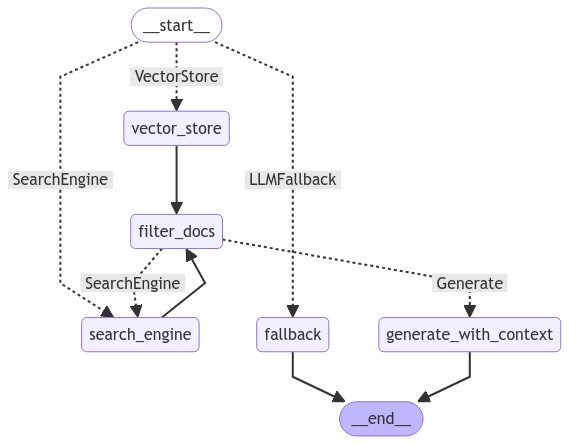

In [162]:
img = Image.open(BytesIO(plot))
display(img)

# Testing App

In [149]:
response = app.invoke({"query": "who is the elected president of Iran?", "chat_history": []})
Markdown(response["generation"])

I'd be happy to help you with any NLP-related queries! However, I must clarify that the previous question about the elected president of Iran falls outside the scope of NLP topics. 

Let's focus on NLP! What's your next question related to Natural Language Processing? Are you struggling with a concept, or would you like to explore a specific area like language models, text classification, or transformers?

In [154]:
response = app.invoke({"query": "Masked Language Modeles", "chat_history": []})
Markdown(response["generation"])

Since you mentioned Masked Language Models, I assume you're referring to a specific technique used in language modeling. Masked Language Models, such as BERT (Bidirectional Encoder Representations from Transformers), use a masked language modeling task to pre-train their models.

In this task, some percentage of the input tokens are randomly replaced with a [MASK] token. The model then predicts the original token. This task helps the model learn to represent each token in the context of the surrounding tokens.

Can you ask a specific question about Masked Language Models or would you like me to elaborate on this topic?

In [ ]:
import gradio as gr
from uuid import uuid4

history = {}
session_id = str(uuid4())

def chat(query):

    # Initialize the chat history for the current session
    if session_id not in history:
        history[session_id] = []

    chat_history = history[session_id]

    # Invoke the app with the current query and chat history
    result = app.invoke({"query": query, "chat_history": chat_history})

    # Separate the response from the retrieved documents
    response = result["generation"]
    documents = result["documents"]

    # Add the current exchange to the chat history
    chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

    if not documents:
        return response, documents

    documents = [
        f"{doc.page_content}\nsource: {doc.metadata['source']}" for doc in documents
    ]

    return response, "\n\n".join(documents)

# Create the Gradio interface
demo = gr.Interface(
    fn=chat,
    inputs=gr.Textbox(label="Question"),
    outputs=[gr.Textbox(label="Response"), gr.Textbox(label="Retrieved Documents")],
    title="RAG Chatbot",
    description="Ask a health-related query and the chatbot will generate a response using Retrieval Augmented Generation.",
)

if __name__ == "__main__":
    demo.launch(share=True, inline=True)
